Starting now
1
2
3
4


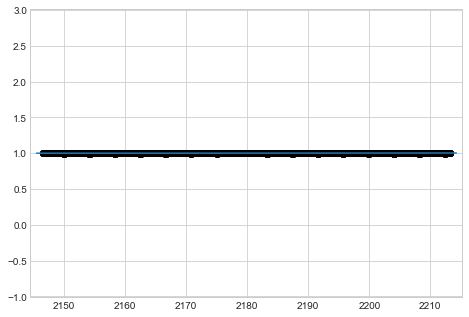

                       3                         2                            
- 3.40406229595641e-8⋅x  + 0.000222820442441946⋅x  - 0.486095451549753⋅x + 354

             
.425669842503

0.00034328870580157915

                              ________________________________________________
                             ╱  2912                                          
                            ╱   ____                                          
                           ╱    ╲                                             
                          ╱      ╲                                            
                         ╱        ╲                                           
0.0185280518620167⋅     ╱         ╱                   ⎛                       
                       ╱         ╱   125617.555443307⋅⎝- 9.60444625094194e-11⋅
                      ╱         ╱                                             
                     ╱          ‾‾‾‾                                          
                   ╲╱          k = 0                                          

______________________________________________________________________________
                                                   

0.0018722119232893126

In [2]:
# Clear defined variables
from IPython.display import display, Latex, Markdown
import sympy as sym
from sympy.plotting import plot
sym.init_printing(use_latex='mathjax')
import math as Math
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import random
import re
import pandas as pd

# Symbols used
j, k, n, v, x, y, a = sym.symbols('j k n v x y a')

should_display = {"all": False, "math": False, "debug": True, "text": False, "diagram": True, "R2": True}
def to_display(to_display, display_type):
    if should_display["all"]:
        display(to_display)
    elif should_display["math"] and display_type == "math":
        display(to_display)
    elif should_display["debug"] and display_type == "debug":
        display(to_display)
    elif should_display["text"] and display_type == "text":
        display(to_display)
        
def calc_R2(model, x_points, y_points):
    display(model)
    # model.replace("x", "sym.Indexed(x, k)")
    model = model.subs(x, sym.Indexed(x, k))
    display(1/len(x_points))
    R2_model = sym.sqrt(1/len(x_points)*sym.Sum(((model) - sym.Indexed(y, k))**2,(k,0,len(x_points) -1)))
    display(R2_model)
    f_R2 = sym.lambdify((x, y), R2_model)
    R2 = f_R2(x_points, y_points)
    display(R2)    
    pass
        

def fit_model(str_model, x_points, y_points):
    still_searching = True
    model = str_model.replace('x', 'sym.Indexed(x, k)')
    free_vars = []
    free_vars_indices = []
    while still_searching:
        match = re.search(r"v_\d+", model)
        if not match:
            still_searching = False
            continue
        matching_text = match.group()
        var_num = re.search(r"\d+", matching_text).group()
        model = model[:match.span()[0]] + "sym.Indexed(v," + str(var_num) + ")" + model[match.span()[1]:]
        free_vars.append(eval("sym.Indexed(v," + str(var_num) + ")"))
        free_vars_indices.append(int(var_num))
    # print(model)

    model = eval(model)
    # Symbols used
    j, k, n, v, x, y, a = sym.symbols('j k n v x y, a')

    # Model to use
    num_free_vars = len(free_vars)
    # model = sym.Indexed(v, 1) * sym.sin(sym.Indexed(x, k)) + sym.Indexed(v,2) * sym.cos(sym.Indexed(x, k))
    # model = Indexed(v, 5)*Indexed(x, k)**4 + Indexed(v, 4)*Indexed(x, k)**3 + Indexed(v, 3)*Indexed(x, k)**2 + Indexed(v, 2)*Indexed(x, k)**1 + Indexed(v, 1)*Indexed(x, k)**0
    to_display("Model to fit:", "text")
    to_display(model, "math")

    # To be minimized
    E = sym.Sum((model-sym.Indexed(y,k))**2,(k,0,len(x_points) -1))
    to_display("Equation to minimize:", "text")
    to_display(E, "math")

    # List of variables to solve for
    to_display("Free variables to solve for:", "text")
    to_display(free_vars, "math")

    solved_eqs = []
    print("Starting now")
    for var_num in free_vars_indices:    
        print(var_num)
        to_display("Solving for: ", "text")
        to_display(sym.Indexed(v, var_num), "math")
        eq = E.diff(sym.Indexed(v, var_num))
        to_display(eq, "math")
        f = sym.lambdify((x, y, *free_vars), eq)
        solved_eq = f(x_points, y_points, *free_vars)
        to_display(solved_eq, "math")
        solved_eqs.append(solved_eq)
        
    # Solve n equations with n unknowns
    solved = sym.solve((solved_eqs), (free_vars), quick=True)

    # Create list of evenly distibuted x-points
    x_list = np.linspace(np.min(x_points) - 1, np.max(x_points) + 1, 10000)
    # solved_model = solved[sym.Indexed(v, 1)] * sym.sin(x) + solved[sym.Indexed(v,2)] * sym.cos(x)
    still_searching = True
    solved_model = str_model
    while still_searching:
        match = re.search(r"v_\d+", solved_model)
        if not match:
            still_searching = False
            continue
        matching_text = match.group()
        var_num = pattern = r"\d+"
        var_num = re.search(r"\d+", matching_text).group()
        if not sym.Indexed(v, var_num) in solved:
            print("excluding {}".format(var_num))
            solved_model = solved_model[:match.span()[0]] + "0" + solved_model[match.span()[1]:]
            continue
        solved_model = solved_model[:match.span()[0]] + "solved[sym.Indexed(v," + str(var_num) + ")]" + solved_model[match.span()[1]:]

    solved_model_eval = eval(solved_model)
    to_display("Solved model evaluated:", "text")
    to_display(solved_model_eval, "math")
    # Generate y-coords for each x-coord
    y_generator = sym.lambdify((x), solved_model_eval)
    y_list = y_generator(x_list)

    # Setup figure
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    fig = ax.set_xlim((np.min(x_points) - 2, np.max(x_points) + 2))
    fig = ax.set_ylim((np.min(y_points) - 2, np.max(y_points) + 2))
    # Display figure
    fig = ax.scatter(x_points, y_points, color='black');
    fig = ax.plot(x_list, y_list)
    if not should_display["diagram"]:
        plt.close() # Don't display
    plt.show()
    # R^2
    to_display(calc_R2(solved_model_eval, x_points, y_points), "R2")
    
    
    
def n_degree_poly(n):
    model = ""
    for i in range(1, n+2):
        model += "+v_" + str(i) + "*x**" + str(n+1-i)
    return model

# Data points
# x_points = [0,1, 2, 3, 4,5,6,7,8,9, 10, 11]
# y_points = [0.5, 4.5, 1, -2, -4, -1, -1.5, -0.3, 1.2, 2.0, 3.4, 5]
x_points = np.linspace(1, 10, 6)
y_points = []
for i in range(0, len(x_points - 1)):
    if i == 0:
        y_points.append(random.random() * 20 - 10)
        continue
    y_points.append(y_points[i-1] + (random.random() * 20) - 10)

for i in range(0, len(x_points)):    
    x_points = np.append(x_points, x_points[i])
    y_points = np.append(y_points, y_points[i])
    
    

url ='https://archive.stsci.edu/hlsps/k2sff/c03/206100000/03150/hlsp_k2sff_k2_lightcurve_206103150-c03_kepler_v1_llc-default-aper.txt'
df = pd.read_csv(url, skiprows=0, header=0, sep=',', index_col=False)

x_points = df[df.columns[0]]
y_points = df[df.columns[1]]

# Model
n = 3
#model = n_degree_poly(n)
#for i in range(1, n + 1):
#    fit_model(n_degree_poly(i), x_points, y_points)

fit_model(n_degree_poly(n), x_points, y_points)
#model = "x*v_1*sym.sin(x+1+a) + x*v_2*sym.sin(x)"
#fit_model(model, x_points, y_points)